**Goal**: we want to preprocess the eye tracking data to exctract the sequence of tokens they look at.

Note that, since we reason at a token level, we will need the tokenizer of the language model.

In [3]:
import project_path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
import json
from eye_tracking.post_processing import *
from eye_tracking.utils import *
from tqdm import tqdm

In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
TASK_NUMBER = 0
USERNAME = "UbeerU"
PATH_INTERACTION_DF = f"../data/eye_tracking_attention/eye_v03/{USERNAME}_{TASK_NUMBER}_char_sequence.csv"
PATH_METADATA = f"../data/eye_tracking_attention/eye_v03/{USERNAME}_{TASK_NUMBER}.json"

## Read Interaction Data

In [9]:
df = pd.read_csv(PATH_INTERACTION_DF)
metadata = json.load(open(PATH_METADATA, 'r'))
df.head()

,line,column,time,time_spent
0,1,1,52903594.53,0.40430
1,1,1,52948543.26,0.45264
2,1,2,52871213.18,0.33936
3,1,2,52903594.53,0.40430
4,1,2,52948543.26,0.45264


In [10]:
metadata.keys()

dict_keys(['user_name', 'task_number', 'source_code', 'att_weights', 'tokenization', 'raw_text'])

In [11]:
metadata["tokenization"][:3]

[{'i': 0, 'l': 1, 'c': 1, 'time': 105852137.78999999, 'w': 0.85694, 't': '/'},
 {'i': 1, 'l': 1, 'c': 2, 'time': 158723350.97, 'w': 1.1963, 't': '*'},
 {'i': 2,
  'l': 1,
  'c': 3,
  'time': 211664550.97,
  'w': 1.6167099999999999,
  't': '*'}]

In [12]:
raw_source_code = metadata["raw_text"]
print(raw_source_code[:80*3])

/*************************************************************************************************/


/*
# In the Tower of Hanoi problem you have to move all the disks

# from the left hand post to the right hand post.

# You can only move 


# Get CodeGen tokenization

In [13]:
# use CodeGen tokenizer to tokenize the source code
from transformers import AutoTokenizer
from attwizard.script.utils import get_model_folder_path

MODEL_FOLDER = "/mnt/huggingface_models"
HUGGING_FACE_REPO = "Salesforce/codegen-16B-multi"

model_folder_path = get_model_folder_path(
    model_folder=MODEL_FOLDER,
    hugging_short_repo=HUGGING_FACE_REPO
)
tokenizer = AutoTokenizer.from_pretrained(model_folder_path)

tmp = tokenizer(raw_source_code, return_tensors="pt")
input_ids = tmp['input_ids']
#attention_mask = tmp['attention_mask']
# convert the ids to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())
# replace spaces and new lines
tokens = [
    token.replace("Ċ", "\n").replace('Ġ', ' ') for token in tokens]
# add the start line position
formatted_tokens = []

line = 1
column = 1
for i, token in enumerate(tokens):
    if any([token == "\n" * r for r in range(10)]):
        for _ in range(token.count("\n")):
            formatted_tokens.append({
                "t": "\n", 
                "i": i,
                "l": line, 
                "c": column}
            )
            line += 1
            column = 1
    else:
        formatted_tokens.append({
            "t": token, 
            "i": i,
            "l": line, 
            "c": column}
        )
        column += len(token)
    
codegen_tokens = formatted_tokens
codegen_tokens[:7]

[{'t': '/', 'i': 0, 'l': 1, 'c': 1},
 {'t': '********************************', 'i': 1, 'l': 1, 'c': 2},
 {'t': '********************************', 'i': 2, 'l': 1, 'c': 34},
 {'t': '********************************', 'i': 3, 'l': 1, 'c': 66},
 {'t': '*/', 'i': 4, 'l': 1, 'c': 98},
 {'t': '\n', 'i': 5, 'l': 1, 'c': 100},
 {'t': '\n', 'i': 5, 'l': 2, 'c': 1}]

## Manual Alignment Inspection

In [14]:
from pprint import pprint
from IPython.display import display, Markdown, HTML

for line_to_inspect in range(1, 5):
    print(f"Line {line_to_inspect})")
    df_chars = df[df["line"] == line_to_inspect]
    # drop duplicates
    df_chars = df_chars.drop_duplicates(subset=["column"])
    # sort by column
    df_chars = df_chars.sort_values(by=["column"])

    n_columns_char = df_chars["column"].max()
    codegen_line_tokens = [
        x for x in codegen_tokens if x['l'] == line_to_inspect]
    start_col_codegen = [x["c"] + len(x["t"]) for x in codegen_line_tokens]
    code_gen_line = "".join([x["t"] for x in codegen_line_tokens])
    n_columns_codegen = 0
    if len(start_col_codegen) > 0:
        n_columns_codegen = max(start_col_codegen)
    #print("#" * 80)
    #print("unique tokens for char-level: ", len(df_chars))
    print("n_columns_char:", n_columns_char, " - n_columns_codegen:", n_columns_codegen)
    print("Line codegen: ", code_gen_line)

Line 1)
n_columns_char: 97  - n_columns_codegen: 101
Line codegen:  /*************************************************************************************************/

Line 2)
n_columns_char: 1  - n_columns_codegen: 2
Line codegen:  

Line 3)
n_columns_char: 1  - n_columns_codegen: 2
Line codegen:  

Line 4)
n_columns_char: 3  - n_columns_codegen: 4
Line codegen:  /*



## Augment with Token information

In [15]:
def get_corresponding_token_id(
        column: int, line: int, formatted_tokens: List[Dict[str, Any]]) -> int:
    """Get the token id of the token at the given line and column."""
    column = int(column)
    line = int(line)
    for i in range(len(formatted_tokens)):
        if formatted_tokens[i]["l"] == line:
            if column >= formatted_tokens[i]["c"] and column < formatted_tokens[i]["c"] + len(formatted_tokens[i]["t"]):
                return formatted_tokens[i]["i"]
    raise ValueError(f"No token found at line {line} and column {column}.")

get_corresponding_token_id(column=1, line=3, formatted_tokens=codegen_tokens)
get_corresponding_token_id(column=1, line=2, formatted_tokens=codegen_tokens)

5

In [16]:
df_tokens = df.copy()
df_tokens["token_id"] = df_tokens.apply(
    lambda row: get_corresponding_token_id(
        column=row["column"], line=row["line"], formatted_tokens=codegen_tokens), axis=1)
df_tokens.head()

,line,column,time,time_spent,token_id
0,1,1,52903594.53,0.40430,0
1,1,1,52948543.26,0.45264,0
2,1,2,52871213.18,0.33936,1
3,1,2,52903594.53,0.40430,1
4,1,2,52948543.26,0.45264,1


In [17]:
def get_corresponding_content(formatted_tokens: List[Dict[str, Any]], idx: int) -> str:
    """Get the content of the token at the given index."""
    return [x["t"] for x in formatted_tokens if x["i"] == idx][0]

df_tokens_with_content = df_tokens.copy()
df_tokens_with_content["content"] = df_tokens_with_content.apply(
    lambda row: get_corresponding_content(
        formatted_tokens=codegen_tokens, idx=row["token_id"]), axis=1)
df_tokens_with_content.head()


,line,column,time,time_spent,token_id,content
0,1,1,52903594.53,0.40430,0,/
1,1,1,52948543.26,0.45264,0,/
2,1,2,52871213.18,0.33936,1,********************************
3,1,2,52903594.53,0.40430,1,********************************
4,1,2,52948543.26,0.45264,1,********************************


In [18]:
df_sequence = df_tokens_with_content.copy()
# keep only those with positive time
df_sequence = df_sequence[df_sequence["time"] > 0]
# drop duplicates on the same token and at the same time
df_sequence = df_sequence.drop_duplicates(subset=["time", "token_id"])
df_sequence.head(5)

,line,column,time,time_spent,token_id,content
0,1,1,52903594.53,0.40430,0,/
1,1,1,52948543.26,0.45264,0,/
2,1,2,52871213.18,0.33936,1,********************************
3,1,2,52903594.53,0.40430,1,********************************
4,1,2,52948543.26,0.45264,1,********************************


## Compute Strength between Tokens

In [19]:
start_token_id = 10
end_token_id = 12
relevant_tokens = [start_token_id, end_token_id]

# check all the occurrences of the two tokens in the sequence
df_relevant_events = df_sequence[df_sequence["token_id"].isin(relevant_tokens)]
df_relevant_events.head(5)

,line,column,time,time_spent,token_id,content
230,5,2,52864986.13,0.50146,10,In
231,5,2,52871731.25,0.45312,10,In
232,5,2,52872102.83,0.35596,10,In
233,5,2,52875095.02,0.46875,10,In
234,5,2,52902138.96,0.40430,10,In


<AxesSubplot:xlabel='time', ylabel='Count'>

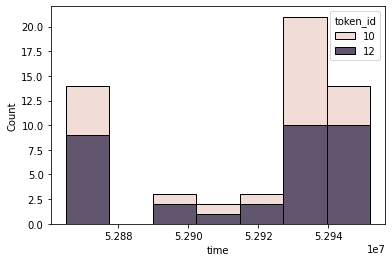

In [20]:
sns.histplot(
    data=df_relevant_events,
    x="time",
    hue="token_id",
    multiple="stack",
)

In [21]:
import scipy.integrate as integrate

decay = 0.75  # unbounded positive integer

def get_connection_strength(
        df: pd.DataFrame,
        start_token_id: int, end_token_id: int, 
        decay: float = 1, starting_value: int = 1) -> float:
    """Get the connection strength between two tokens.
    
    The connection strength is the summation of the integral between the 
    times of two consecutive events, over all possible orederd pairs.
    """
    # get all the pairs of occurrences when the starting token comes before the ending token
    token_pair_contribution = 0
    df_starting_events = df[df["token_id"] == start_token_id]
    df_ending_events = df[df["token_id"] == end_token_id]
    for s, s_event in df_starting_events.iterrows():
        #print("Start: ", s_event["time"])
        # get all subsequent events
        df_to_compare = df_ending_events[df_ending_events["time"] > s_event["time"]]
        for e, e_event in df_to_compare.iterrows():
            #print("\tEnd: ", e_event["time"])
            start_time = s_event["time"]
            end_time = e_event["time"]
            diff_time = end_time - start_time
            #print("\tDiff: ", diff_time)
            result = integrate.quad(lambda t: starting_value * np.exp(-decay*t), 0, diff_time)
            #print("\t", result)
            additional_contribution = result[0]
            #print("\tContribution: ", additional_contribution)
            token_pair_contribution += additional_contribution
    return token_pair_contribution

get_connection_strength(
    df=df_sequence,
    start_token_id=start_token_id, end_token_id=end_token_id, decay=decay)


292.0000000224737

## Matrix Version

### 1. Compute Timings

In [22]:
import torch

decay = 1
starting_value = 1

df = df_sequence.sort_values(by=["time"])

n_events = len(df)
event_matrix = torch.zeros((n_events, n_events))

n_tokens = len(codegen_tokens)
followup_matrix = torch.zeros((n_tokens, n_tokens))


# get the corresponding token indices
token_indices = df["token_id"].values

# get the times of the events
times = torch.tensor(df["time"].values).expand(n_events, n_events).t()
times = (times - times.min()) / 1000
# get the difference between times
diff_times = times - times.t()
# keep only the positive differences
diff_times = torch.clamp(diff_times, min=0)
diff_times[:10, :10]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4853, 0.4853, 0.4853, 0.4853, 0.4853, 0.4853, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4853, 0.4853, 0.4853, 0.4853, 0.4853, 0.4853, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4853, 0.4853, 0.4853, 0.4853, 0.4853, 0.4853, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4853, 0.4853, 0.4853, 0.4853, 0.4853, 0.4853, 0.0000, 0.0000, 0.0000,
         0.0000]], dtype=tor

In [23]:
# parallel solution

# Numeric integration
#integrate.quad(
#        lambda t: starting_value * np.exp(-decay*t), 0, diff_time)

# Analytical integration
# lambda diff_time: (1/(-decay)) * np.exp(-decay * diff_time) - 1

decay = 1

def compute_integral_attention(diff_time):
    """Analytics integran evaluated in 0, diff_time."""
    global decay
    c = -decay
    return (1/(c)) * (np.exp(c * diff_time) - 1)


decayed_diff = diff_times.apply_(
    lambda diff_time: compute_integral_attention(diff_time))
decayed_diff


tensor([[-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        ...,
        [1., 1., 1.,  ..., -0., -0., -0.],
        [1., 1., 1.,  ..., -0., -0., -0.],
        [1., 1., 1.,  ..., -0., -0., -0.]], dtype=torch.float64)

<AxesSubplot:ylabel='Count'>

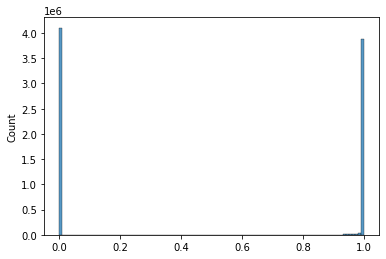

In [24]:
# get all the values of the matrix as numpy array
decayed_diff_values = decayed_diff.reshape(-1).numpy()
sns.histplot(data=decayed_diff_values)

### 2. Compute Strength

In [25]:
# parallel solution with sorting
#decayed_diff = decayed_diff.contiguous()

indices = torch.tensor(token_indices)
arg_sort = torch.argsort(indices)
arg_sort = arg_sort.contiguous()

sorted_indices = torch.index_select(indices, 0, arg_sort)
sorted_indices = sorted_indices.contiguous()

to_sort_decayed_diff = decayed_diff
# sort the rows 
sorted_row_decayed_diff = torch.index_select(to_sort_decayed_diff, 0, arg_sort)
# sort the columns
sorted_row_and_col_decayed_diff = torch.index_select(sorted_row_decayed_diff, 1, arg_sort)

decayed_diff = sorted_row_and_col_decayed_diff.contiguous()

# for each pair of tokens
for i in tqdm(range(n_tokens)):
    # compute the index of the first row
    # get the first occurrence of the token i in the sorted indices
    occurrences_of_i = (sorted_indices == i).nonzero(as_tuple=True)[0]
    if len(occurrences_of_i) == 0:
        followup_matrix[i, :] = 0
        continue
    first_row_index = occurrences_of_i[0]
    # compute the index of the last row
    last_row_index = occurrences_of_i[-1]
    for j in range(n_tokens):
        # compute the index of the first column
        occurrences_of_j = (sorted_indices == j).nonzero(as_tuple=True)[0]
        if len(occurrences_of_j) == 0:
            followup_matrix[i, j] = 0
            continue
        first_col_index = occurrences_of_j[0]
        # compute the index of the last column
        last_col_index = occurrences_of_j[-1]
        # slice the matrix between the first and last row and columns
        slice_matrix = decayed_diff[
            first_row_index:last_row_index+1, 
            first_col_index:last_col_index+1]
        # compute the sum of the matrix
        strength = slice_matrix.sum()
        # store the value in the followup matrix
        followup_matrix[i, j] = strength

100%|██████████| 285/285 [00:03<00:00, 84.03it/s]


### 3. Visualize Follow-up Strength

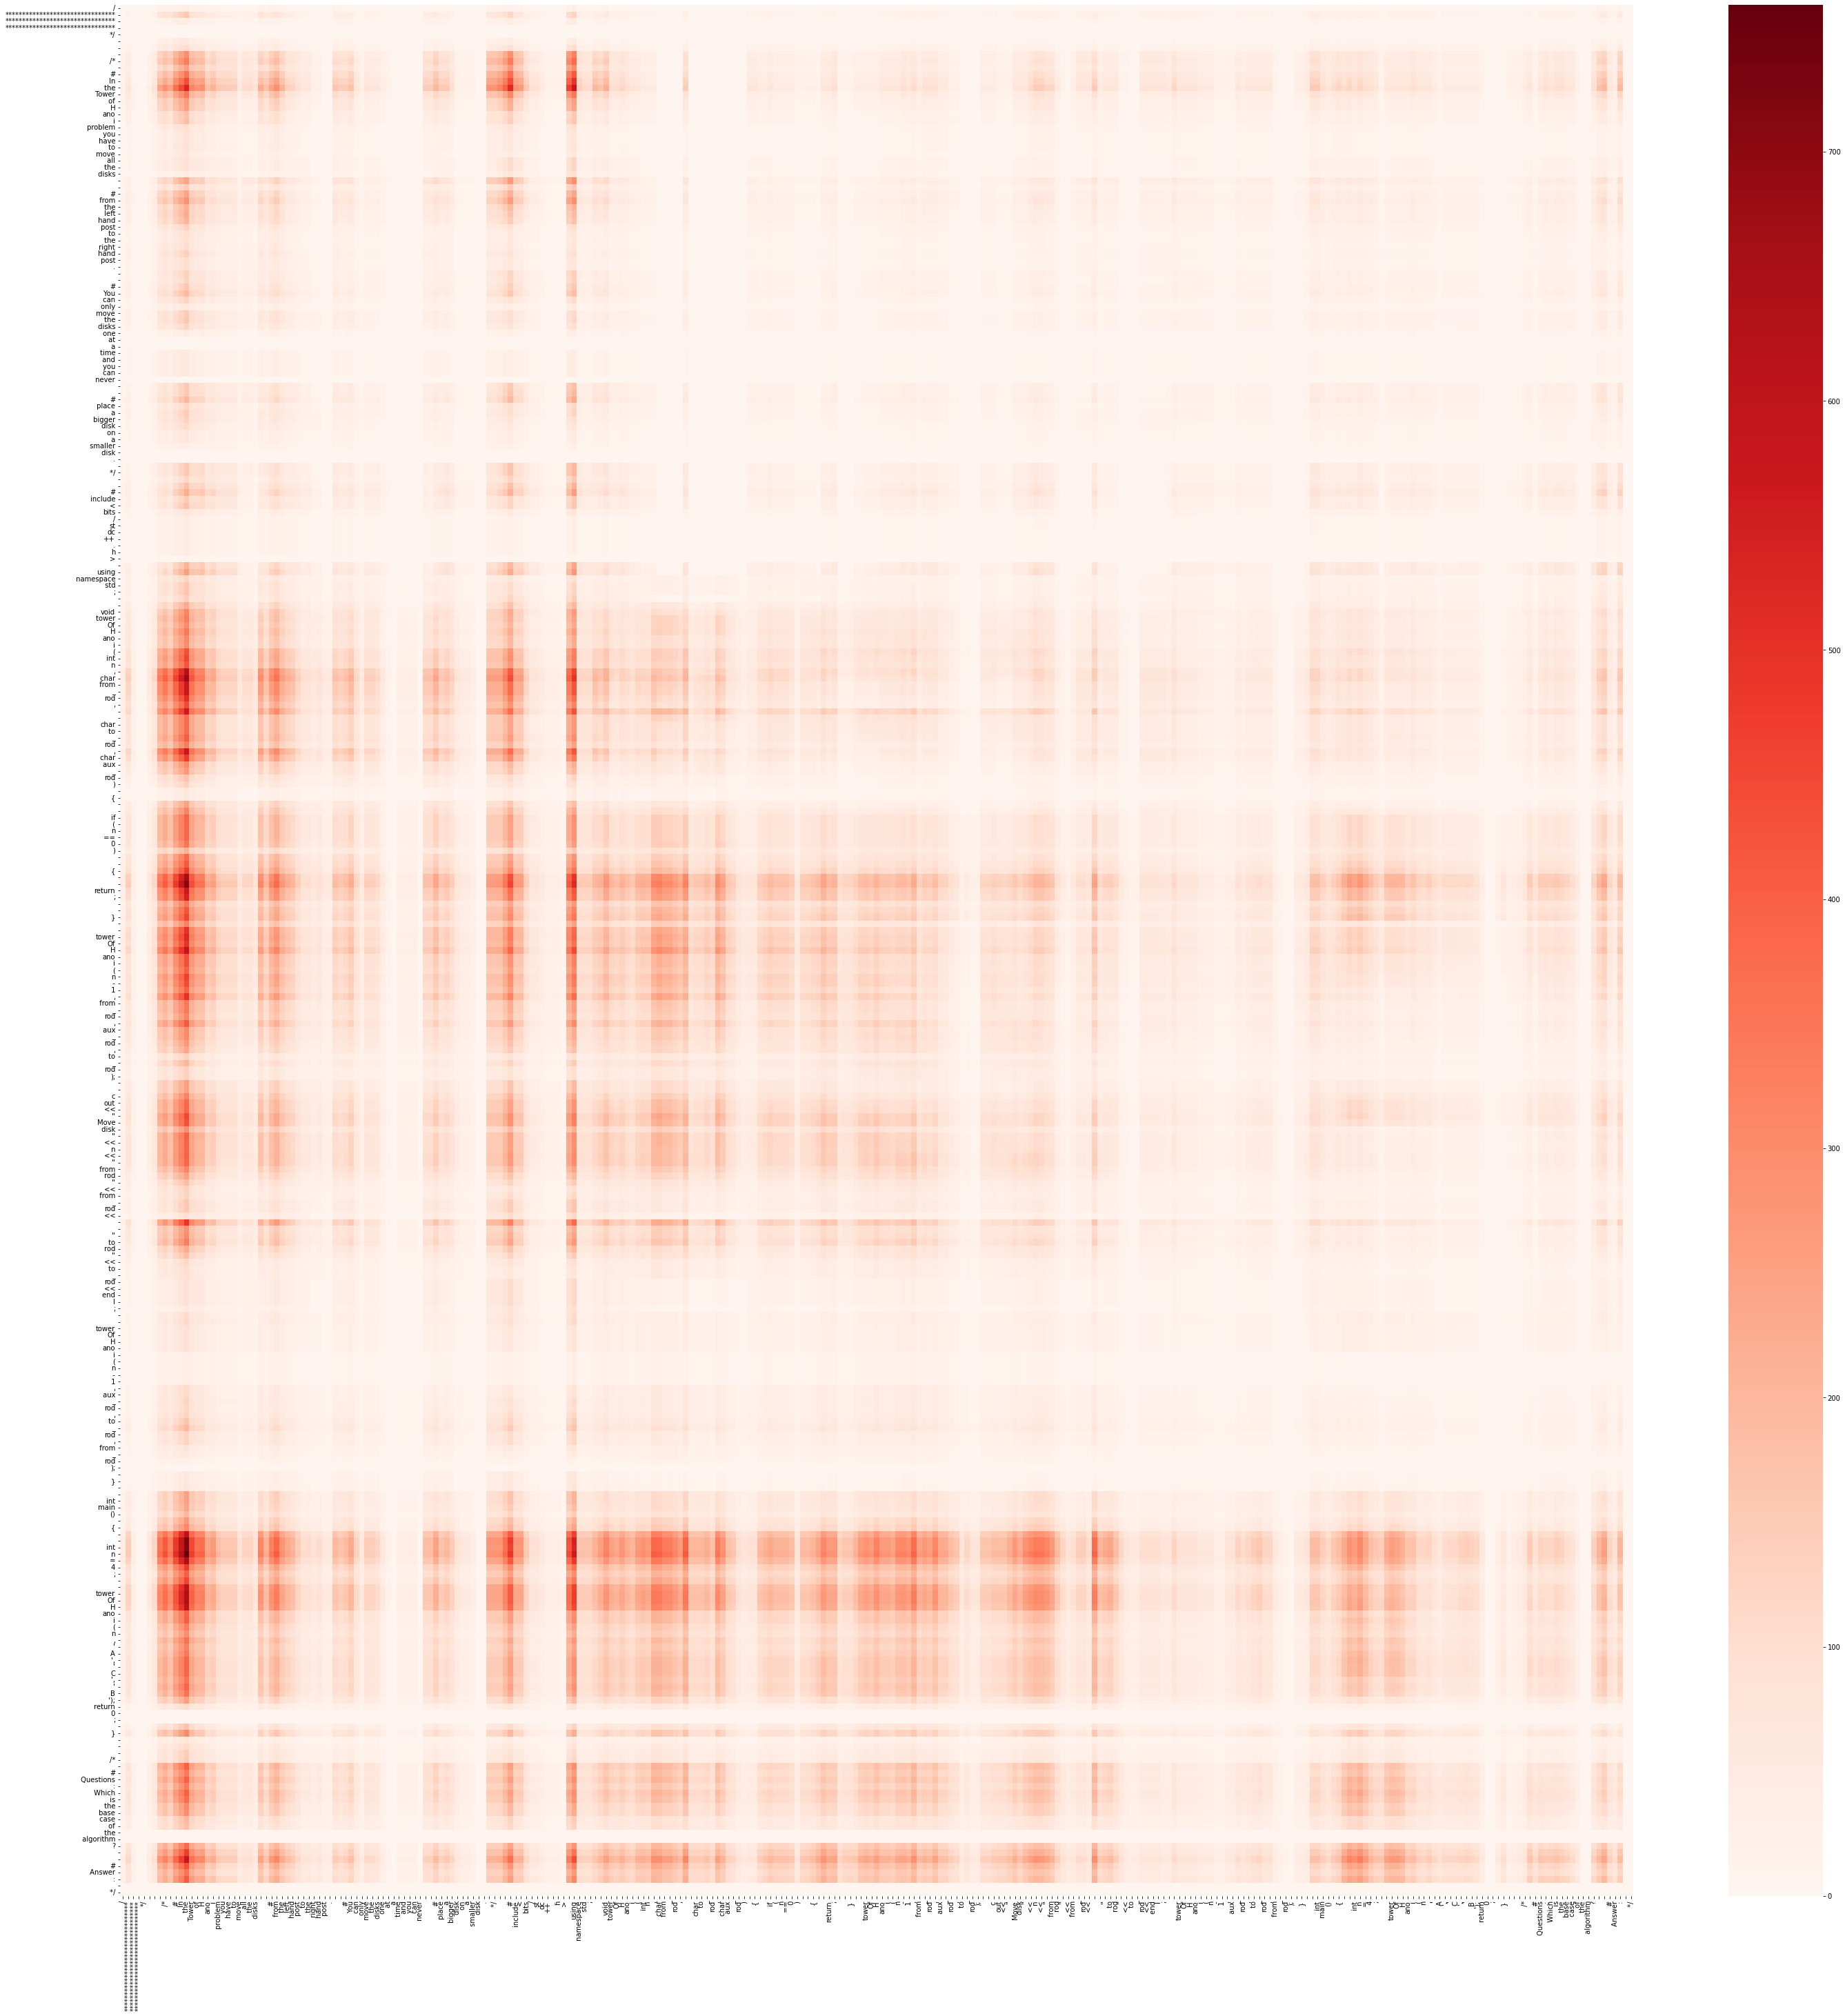

In [29]:
tokens = [x["t"] for x in codegen_tokens]
max_char = max([len(x) for x in tokens])
size = len(tokens)
fig, ax = plt.subplots(figsize=(size/7, size/7))
sns.heatmap(
    followup_matrix,
    xticklabels=tokens,
    yticklabels=tokens,
    cmap="Reds"
)
plt.tight_layout()

In [30]:
# visualize some strong pairs
TOP_K = 15

linear_followup_matrix = followup_matrix.reshape(-1)
arg_sort = torch.argsort(linear_followup_matrix)
lin_indices_top_k = arg_sort[-TOP_K:].tolist()
for counter, lin_i in enumerate(lin_indices_top_k):
    i = lin_i // n_tokens
    j = lin_i % n_tokens
    strength = linear_followup_matrix[lin_i]
    #print(i, j, linear_followup_matrix[lin_i])
    from_token = codegen_tokens[i]["t"].replace("\n", "\\n")
    to_token = codegen_tokens[j]["t"].replace("\n", "\\n")
    print(f"{counter}) {from_token} -- ({i}) {strength:.2f} ({j}) --> {to_token} ")


0) H -- (142) 597.75 (12) -->  the 
1) H -- (241) 605.00 (12) -->  the 
2) \n -- (230) 609.92 (12) -->  the 
3)      -- (238) 610.00 (12) -->  the 
4)  n -- (233) 617.97 (11) -->  In 
5) , -- (100) 627.73 (12) -->  the 
6) Of -- (240) 639.00 (12) -->  the 
7) tower -- (239) 639.00 (12) -->  the 
8)  = -- (234) 648.00 (12) -->  the 
9) \n -- (131) 659.99 (12) -->  the 
10)  char -- (101) 680.00 (12) -->  the 
11)          -- (132) 708.55 (12) -->  the 
12) int -- (232) 715.92 (12) -->  the 
13)      -- (231) 720.92 (12) -->  the 
14)  n -- (233) 758.92 (12) -->  the 


### 4. Map to lines

In [31]:
lines = [t["l"] for t in codegen_tokens]
lines = torch.tensor(lines).contiguous()

n_lines = max(lines)

followup_line_matrix = torch.zeros((n_lines, n_lines))


followup_matrix = followup_matrix.contiguous()

# for each pair of tokens
for i in tqdm(range(n_lines)):
    occurrences_of_line_i = (lines == i + 1).nonzero(as_tuple=True)[0]
    first_row_index = occurrences_of_line_i[0]
    last_row_index = occurrences_of_line_i[-1]
    for j in range(n_lines):
        occurrences_of_line_j = (lines == j + 1).nonzero(as_tuple=True)[0]
        first_col_index = occurrences_of_line_j[0]
        last_col_index = occurrences_of_line_j[-1]
        slice_matrix = followup_matrix[
            first_row_index:last_row_index+1, 
            first_col_index:last_col_index+1]
        line_strength = slice_matrix.sum()
        followup_line_matrix[i, j] = line_strength




100%|██████████| 41/41 [00:00<00:00, 680.37it/s]


In [32]:
line_contents = metadata["raw_text"].split("\n")
pprint(line_contents[:5])

['/*************************************************************************************************/',
 '',
 '',
 '/*',
 '# In the Tower of Hanoi problem you have to move all the disks']


/tmp/ipykernel_3739185/3095432066.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


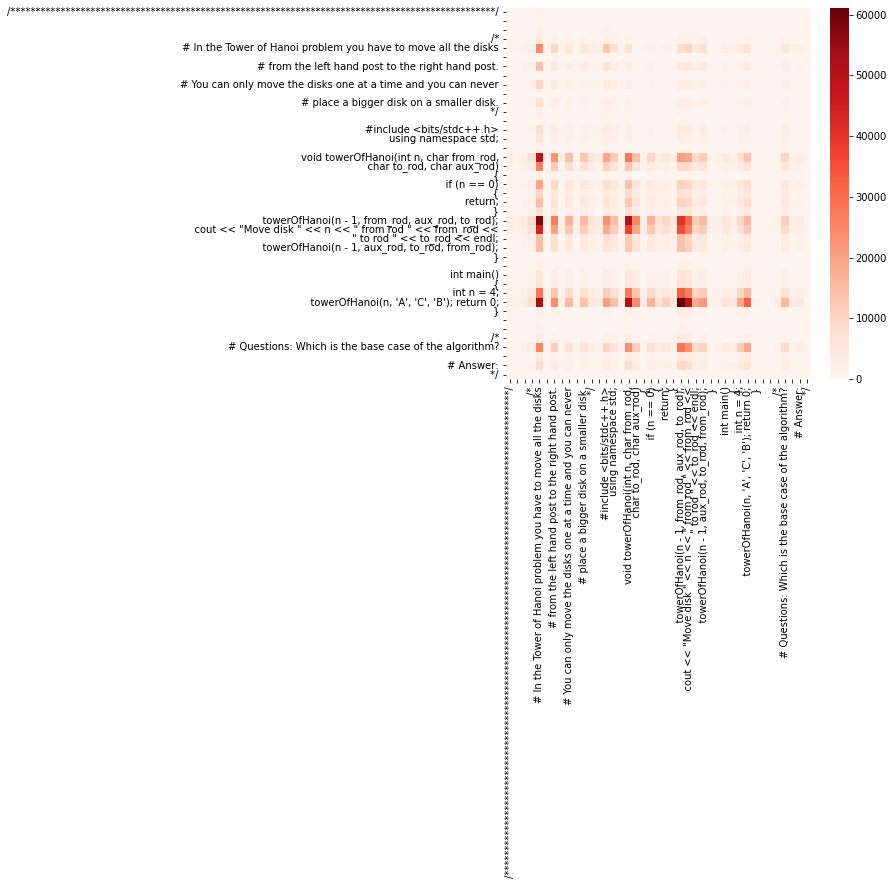

In [34]:
line_contents = metadata["raw_text"].split("\n")
size = len(line_contents)
fig, ax = plt.subplots(figsize=(size/6, size/6))
sns.heatmap(
    followup_line_matrix,
    xticklabels=line_contents,
    yticklabels=line_contents,
    cmap="Reds",
    ax=ax
)
fig.tight_layout()

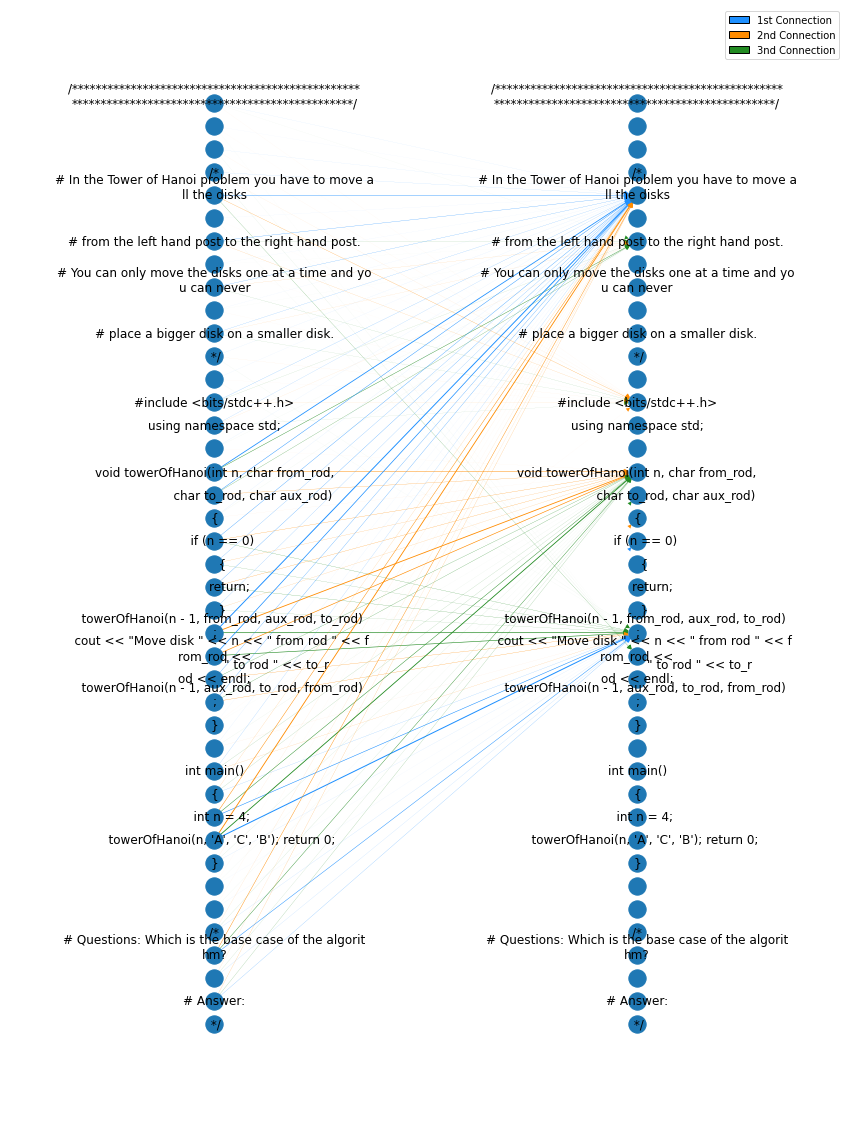

In [188]:
import networkx as nx
from matplotlib.patches import Patch

TOP_K_FOLLOWUP = 3
LINE_SPACING = .3
FIGSIZE = (15, n_lines * .5)
MAX_CHAR_PER_LINE = 50

G = nx.DiGraph()

pos = {}

def convert_to_multiline(in_string: str, max_char_per_line: int) -> str:
    """Convert a single line to a multiline string."""
    out_string = ""
    for i in range(0, len(in_string), max_char_per_line):
        out_string += in_string[i:i+max_char_per_line] + "\n"
    return out_string


condensed_line_content =[
    l 
    if len(l) < MAX_CHAR_PER_LINE 
    else convert_to_multiline(l, MAX_CHAR_PER_LINE) 
    for l in line_contents
]

max_val = followup_line_matrix.max()


# add destination node (aka target lines)
for i in range(n_lines):
    node_id = f"line_{i}_dest"
    G.add_node(node_id, label=condensed_line_content[i], color="red")
    pos[node_id] = (1, - i * LINE_SPACING)

# add starting nodes + top k followup edges
for i in range(n_lines):
    top_k = torch.argsort(followup_line_matrix[i, :])[-TOP_K_FOLLOWUP:]
    top_k = top_k.tolist()[::-1]
    node_id = f"line_{i}_src"
    G.add_node(node_id, label=condensed_line_content[i], color="blue")
    pos[node_id] = (0, - i * LINE_SPACING)
    for connection_rank, j in enumerate(top_k):
        # print(f"Rank {connection_rank}: {followup_line_matrix[i, j]/max_val}")
        target_node_id = f"line_{j}_dest"
        if connection_rank == 0:
            edge_color = "dodgerblue"
        elif connection_rank == 1:
            edge_color = "darkorange"
        else:
            edge_color = "forestgreen"
        G.add_edge(node_id, target_node_id, weight=followup_line_matrix[i, j]/max_val, color=edge_color)


# draw graph with custom positions
fig, ax = plt.subplots(figsize=FIGSIZE)
node_labels = nx.get_node_attributes(G, 'label')

edges = G.edges()
edge_colors = [G[u][v]['color'] for u,v in edges]
edge_weights = [G[u][v]['weight'] for u,v in edges]
nx.draw(G, pos, with_labels=True, labels=node_labels, 
    edge_color=edge_colors, width=edge_weights)
# add legend
legend_elements = [
    Patch(facecolor='dodgerblue', edgecolor='black', label='1st Connection'),
    Patch(facecolor='darkorange', edgecolor='black', label='2nd Connection'),
    Patch(facecolor='forestgreen', edgecolor='black', label='3nd Connection'),
]
plt.legend(handles=legend_elements, loc='upper right')
plt.margins(x=0.4)


# Debug Empty lines in the matrix

In [22]:
from eye_tracking.post_processing import get_followup_matrix
from attwizard.shaper import aggregate_dim_tokens_to_line

Computing the Follow-Up Matrix for TOKENS...


/home/eaftan/copilot-attention/eye_tracking/post_processing.py:659: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1582.)
  decayed_diff[np.isnan(decayed_diff)] = 0
  5%|▌         | 12/229 [00:00<00:01, 119.26it/s]

No occurrence of token at position 3
No occurrence of token at position 4
No occurrence of token at position 12
No occurrence of token at position 22


 22%|██▏       | 50/229 [00:00<00:01, 109.67it/s]

No occurrence of token at position 35
No occurrence of token at position 36
No occurrence of token at position 53


 46%|████▋     | 106/229 [00:01<00:01, 98.14it/s]

No occurrence of token at position 88


 69%|██████▉   | 159/229 [00:01<00:00, 101.66it/s]

No occurrence of token at position 147
No occurrence of token at position 148


 93%|█████████▎| 214/229 [00:02<00:00, 106.56it/s]

No occurrence of token at position 194
No occurrence of token at position 195
No occurrence of token at position 196
No occurrence of token at position 213
No occurrence of token at position 214


100%|██████████| 229/229 [00:02<00:00, 103.92it/s]

No occurrence of token at position 226
No occurrence of token at position 227
No occurrence of token at position 228
Computing the Follow-Up Matrix for LINES...



/home/eaftan/copilot-attention/eye_tracking/post_processing.py:695: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1582.)
  followup_matrix[np.isnan(followup_matrix)] = 0
/home/eaftan/copilot-attention/eye_tracking/post_processing.py:708: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1582.)
  followup_line_matrix[np.isnan(followup_line_matrix)] = 0


Saving UbeerU_0_followup_matrix_tokens.png...
Saving UbeerU_0_followup_matrix_lines.png...


/home/eaftan/copilot-attention/eye_tracking/post_processing.py:575: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


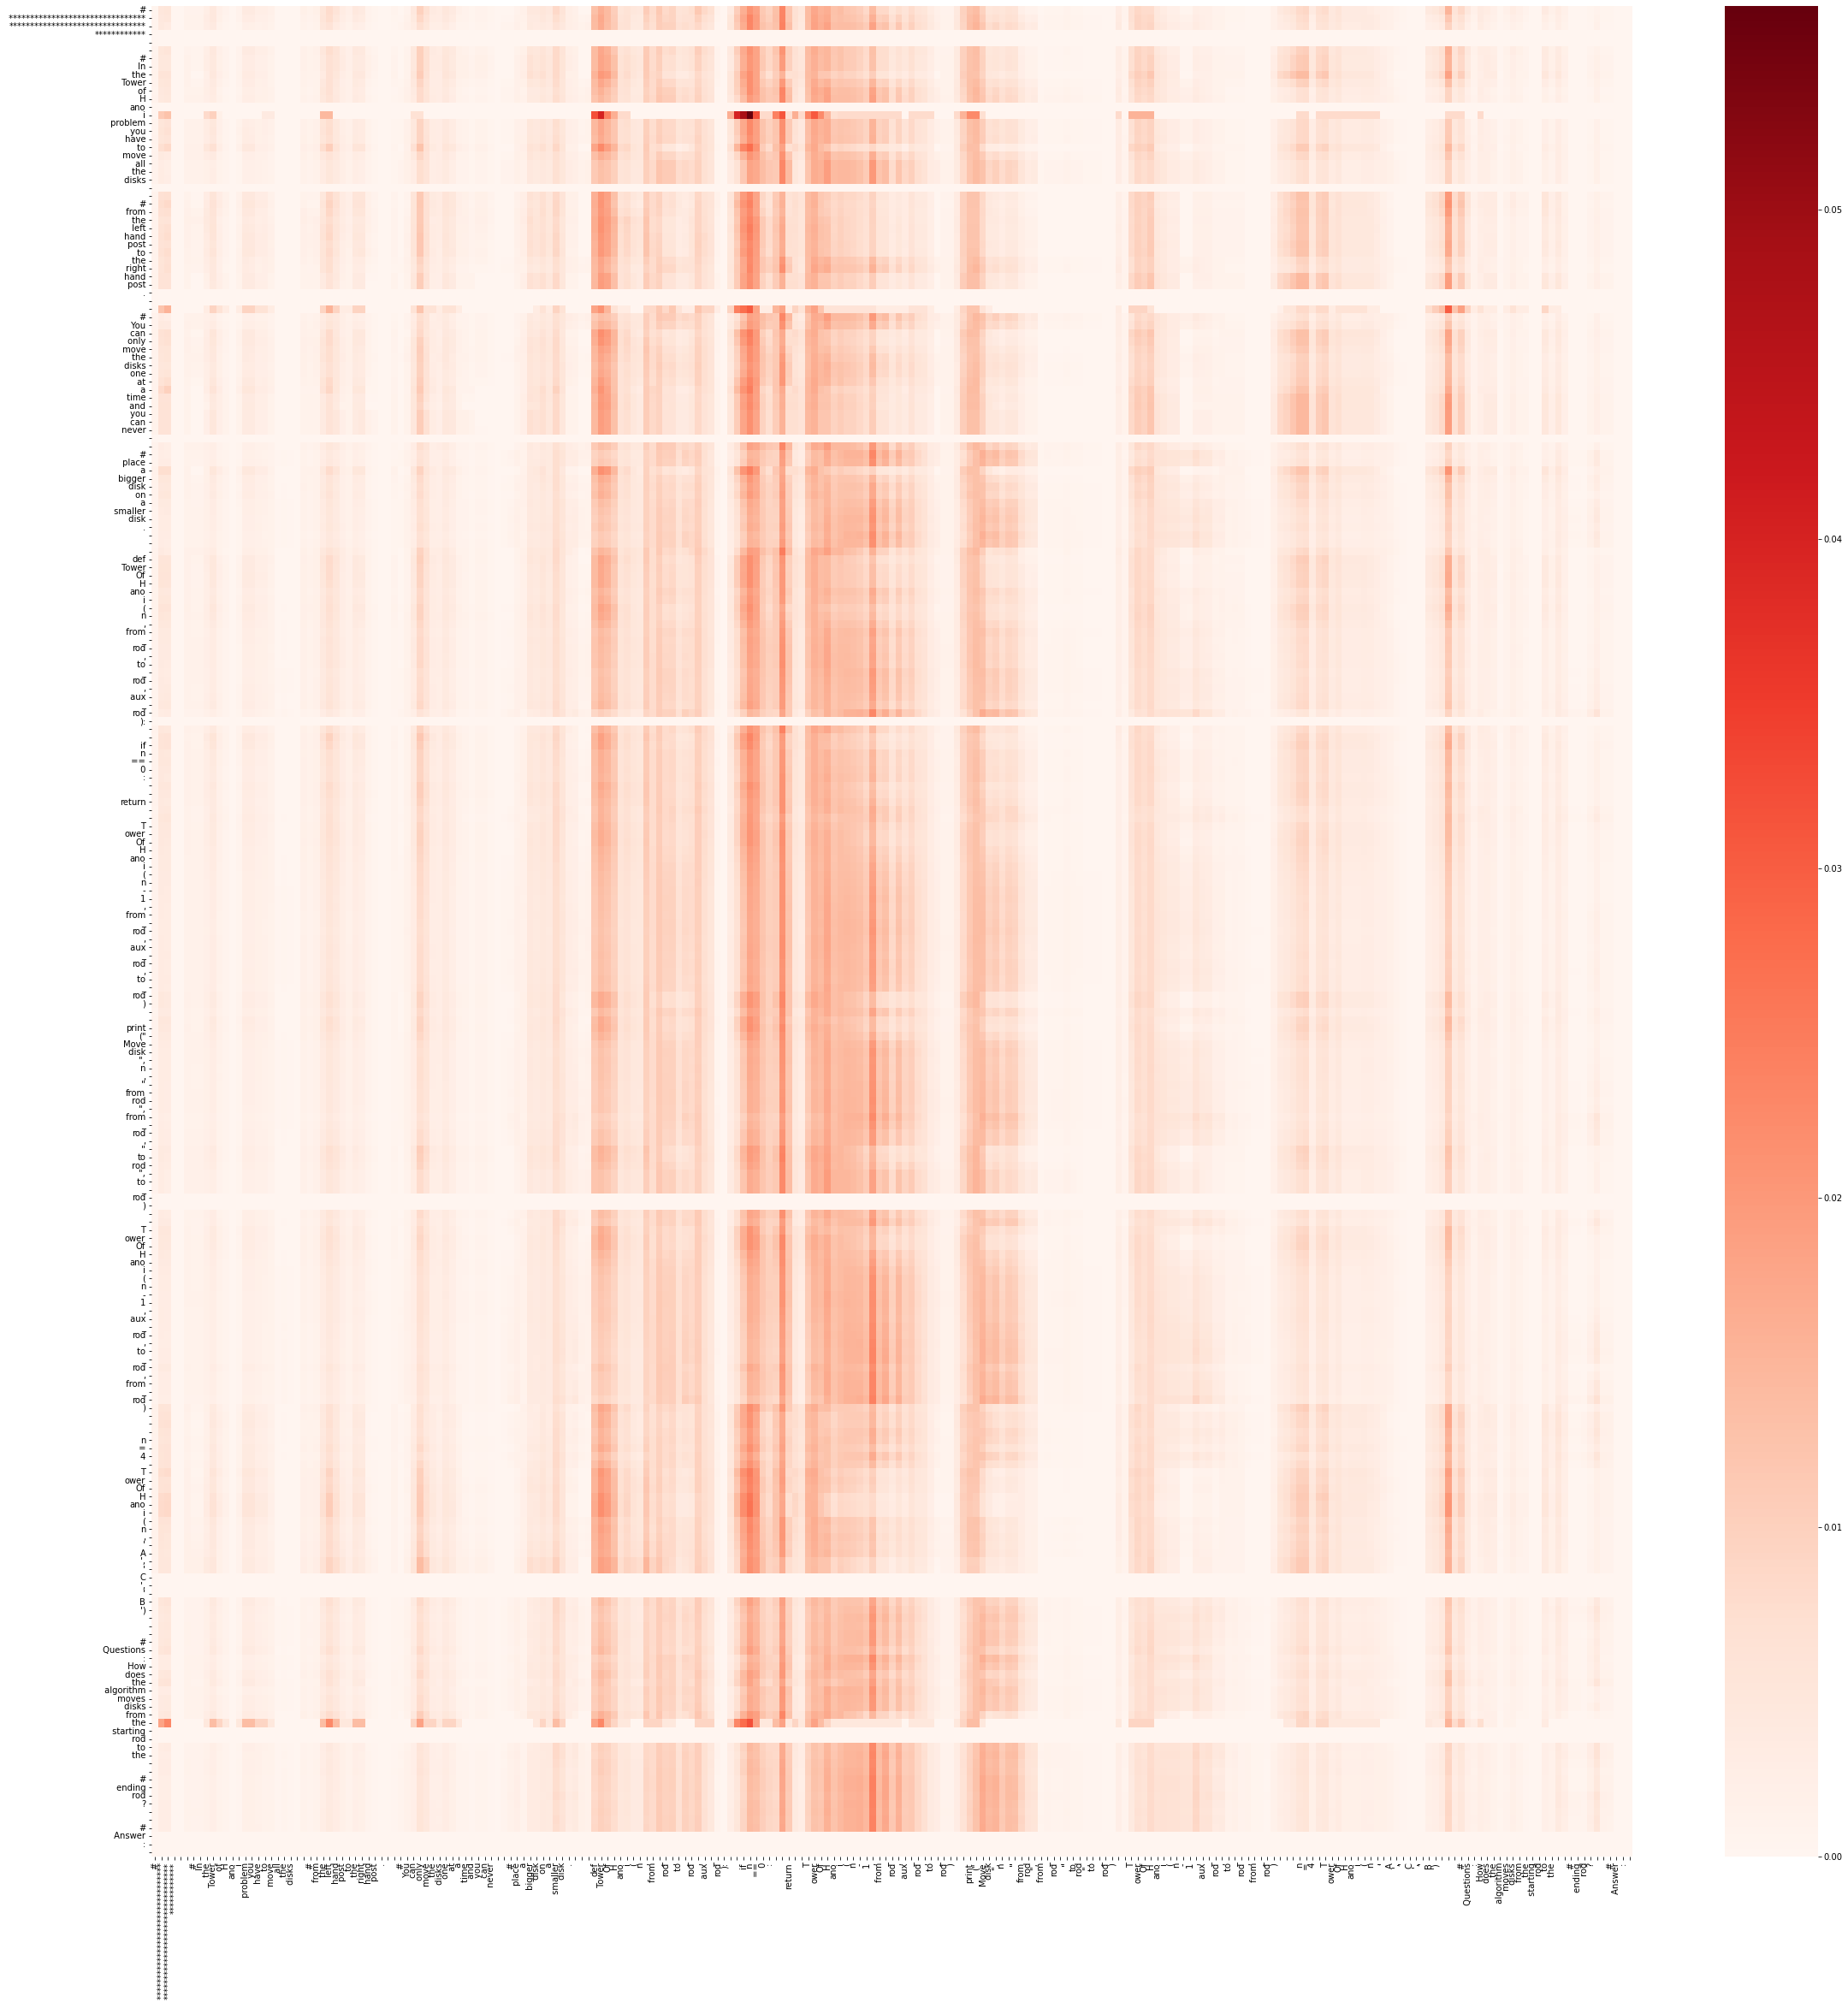

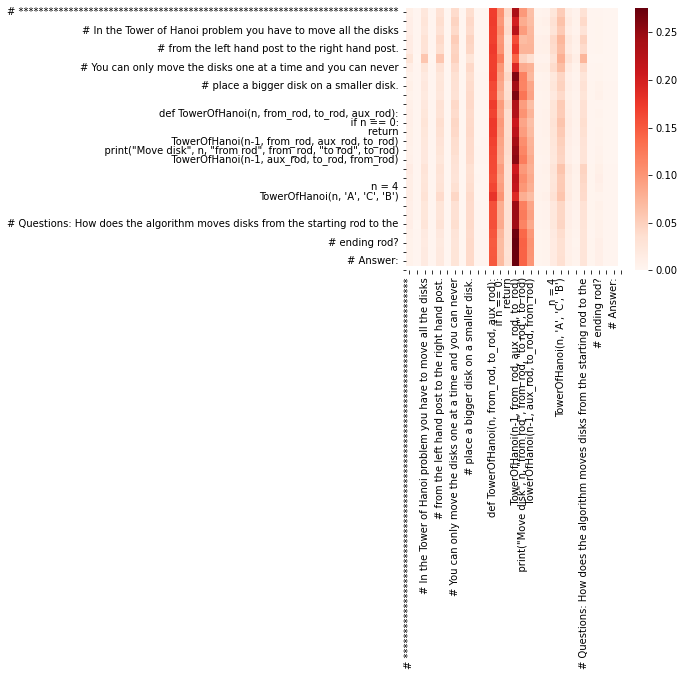

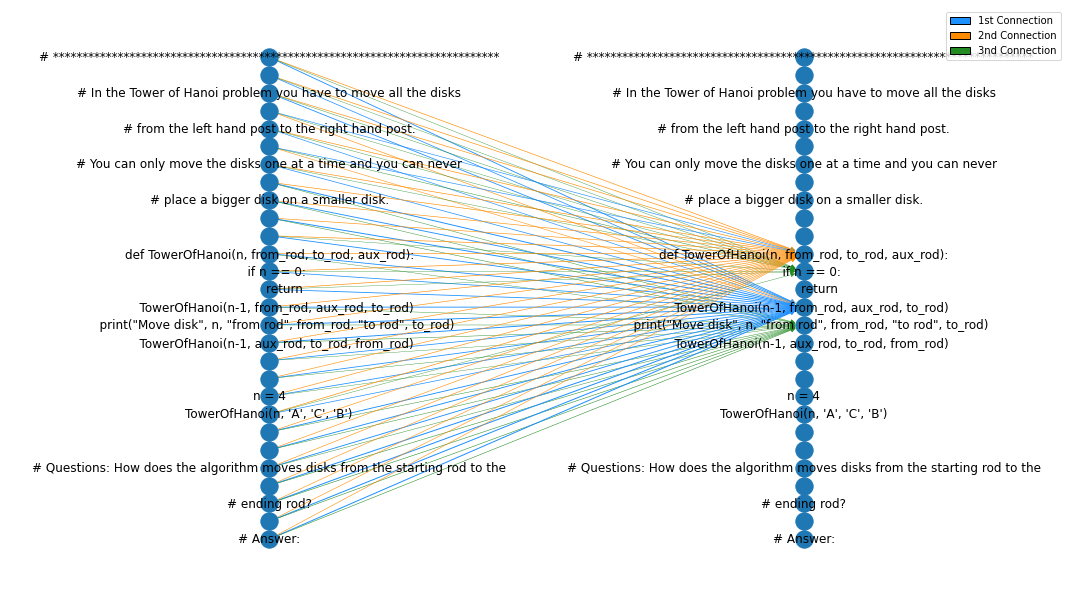

In [68]:
get_followup_matrix(
    username=USERNAME,
    task_number=TASK_NUMBER,
    decay=1,
    normalization="turn_lines_into_prob_distrib",
    tokenizer="Salesforce/codegen-16B-multi",
    model_folder="/mnt/huggingface_models",
    output_folder="../tmp",
    override_everything=True,
    debug=False)

In [62]:
lines = raw_text.split("\n")
len(lines)

29

In [63]:
lines

['# ****************************************************************************',
 '',
 '# In the Tower of Hanoi problem you have to move all the disks',
 '',
 '# from the left hand post to the right hand post.',
 '',
 '# You can only move the disks one at a time and you can never',
 '',
 '# place a bigger disk on a smaller disk.',
 '',
 '',
 'def TowerOfHanoi(n, from_rod, to_rod, aux_rod):',
 '    if n == 0:',
 '        return',
 '    TowerOfHanoi(n-1, from_rod, aux_rod, to_rod)',
 '    print("Move disk", n, "from rod", from_rod, "to rod", to_rod)',
 '    TowerOfHanoi(n-1, aux_rod, to_rod, from_rod)',
 '',
 '',
 'n = 4',
 "TowerOfHanoi(n, 'A', 'C', 'B')",
 '',
 '',
 '# Questions: How does the algorithm moves disks from the starting rod to the',
 '',
 '# ending rod?',
 '',
 '# Answer:',
 '']

In [65]:
metadata = {
    "raw_text": raw_text
}

In [66]:
line_except_last = metadata["raw_text"].split("\n")
# remove last line if empty
if line_except_last[-1] == "":
    line_except_last = line_except_last[:-1]
line_contents = line_except_last.split("\n")
fig, ax = visualize_followup_graph_side_by_side(
    adj_mat=followup_line_matrix,
    from_seq=line_contents,
    to_seq=line_contents,
    multiline_labels=False
)
#fig.tight_layout()
#fig.savefig(f"{username}_{task_number}_network_from_to_line.png")

AttributeError: 'list' object has no attribute 'split'

In [54]:
line_indices = np.array(
    [t["l"]-1 for t in model_tokenization]
)
line_indices


array([ 0,  0,  0,  0,  0,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9, 10,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 17, 18, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 22, 23, 23,
       23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 25, 25,
       25, 25, 25, 26, 27

In [50]:
content = """HappyGrandy delivers an all-in-one solution for elderly to easily video-call beloved ones and directly access health care services with their existing TV using an hassle-free user interface."""
len(content)

190

In [33]:
[(t["t"], t["l"] )for t in model_tokenization[:10]]

[('#', 1),
 (' ********************************', 1),
 ('********************************', 1),
 ('************', 1),
 ('\n', 1),
 ('\n', 2),
 ('#', 3),
 (' In', 3),
 (' the', 3),
 (' Tower', 3)]

In [45]:
max([t['l'] for t in model_tokenization] )

28

In [46]:
[t for t in model_tokenization if t['l'] == 28]

[{'t': '#', 'i': 222, 'l': 28, 'c': 1},
 {'t': ' Answer', 'i': 223, 'l': 28, 'c': 2},
 {'t': ':', 'i': 224, 'l': 28, 'c': 9},
 {'t': '\n', 'i': 225, 'l': 28, 'c': 10}]

Line 0)  tensor([0.0105, 0.0098, 0.0082, 0.0000, 0.0000, 0.0112, 0.0099, 0.0099, 0.0128,
        0.0112])
Line 1)  tensor([0.0011, 0.0011, 0.0013, 0.0000, 0.0000, 0.0011, 0.0014, 0.0014, 0.0014,
        0.0014])
Line 2)  tensor([0.0273, 0.0243, 0.0195, 0.0000, 0.0000, 0.0263, 0.0234, 0.0234, 0.0243,
        0.0225])
Line 3)  tensor([0.0018, 0.0014, 0.0013, 0.0000, 0.0000, 0.0016, 0.0017, 0.0017, 0.0014,
        0.0014])
Line 4)  tensor([0.0366, 0.0327, 0.0254, 0.0000, 0.0000, 0.0366, 0.0344, 0.0344, 0.0329,
        0.0303])
Line 5)  tensor([0.0007, 0.0005, 0.0004, 0.0000, 0.0000, 0.0008, 0.0009, 0.0009, 0.0012,
        0.0007])
Line 6)  tensor([0.0431, 0.0384, 0.0327, 0.0000, 0.0000, 0.0460, 0.0476, 0.0476, 0.0483,
        0.0408])
Line 7)  tensor([0.0000, 0.0004, 0.0008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0005])
Line 8)  tensor([0.0389, 0.0356, 0.0329, 0.0000, 0.0000, 0.0415, 0.0452, 0.0452, 0.0466,
        0.0406])
Line 9)  tensor([0.0000, 0.0007, 0.0013, 0.000

/tmp/ipykernel_3884197/597516316.py:5: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1582.)
  followup_line_matrix[np.isnan(followup_line_matrix)] = 0


<AxesSubplot:>

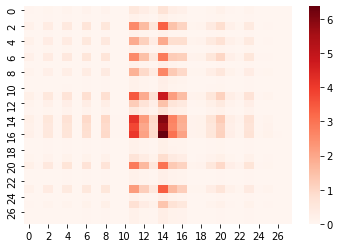

In [38]:
followup_line_matrix = followup_matrix

# fill nan of torch tensor with zero
followup_line_matrix = followup_line_matrix.to(torch.float)
followup_line_matrix[np.isnan(followup_line_matrix)] = 0

followup_line_matrix = aggregate_dim_tokens_to_line(
    att_tensor=followup_line_matrix, line_indices=line_indices,
    dim=1)
followup_line_matrix = aggregate_dim_tokens_to_line(
    att_tensor=followup_line_matrix, line_indices=line_indices,
    dim=0)

sns.heatmap(
    followup_line_matrix,
    cmap="Reds"
)

# Miscellanea

In [ ]:
from joblib import delayed, Parallel
import itertools
from functools import partial

partial_get_strength = partial(get_connection_strength, df=df_sequence, decay=decay)

def square(x): return x*x

NUM_CPUS = 10
decay = 1
n_tokens = len(codegen_tokens)

for i, j in itertools.product(range(n_tokens), range(n_tokens)):
    print(i, j)
    break
values = Parallel(n_jobs=NUM_CPUS)(
    delayed(get_connection_strength)(df_sequence, i, j) 
    for i, j in tqdm(itertools.product(range(n_tokens), range(n_tokens))))

values[:5]


values = Parallel(n_jobs=NUM_CPUS)(delayed(square)(x) for x in range(1000))

followup_matrix = np.zeros((n_tokens, n_tokens))
for i in tqdm(range(n_tokens)):
    for j in range(n_tokens):
        followup_matrix[i, j] = get_connection_strength(
            df=df_sequence,
            start_token_id=i, end_token_id=j, decay=decay)


In [ ]:
target_row = 0
target_col = 1
n_events = 5
a = torch.tensor([
    [1, 2, 3, 4, 5],
    [4, 5, 6, 7, 8],
    [7, 8, 9, 10, 11],
    [10, 11, 12, 13, 14],
    [13, 14, 15, 16, 17],
])
indices = torch.tensor([0, 1, 2, 1, 0])
row_mask = (indices == target_row).expand(n_events, n_events).t()
print("Row filter")
print(row_mask)
col_mask = (indices == target_col).expand(n_events, n_events)
print("Col filter")
print(col_mask)

pointer_mask = row_mask & col_mask
print("Pointer mask")
print(pointer_mask)

replated_pairs = torch.masked_select(a, pointer_mask)
print("Replated pairs")
print(replated_pairs)
strength = replated_pairs.sum()
strength


# sequential solution
# decay the differences
decayed_diff = diff_times.apply_(
    lambda diff_time: integrate.quad(
        lambda t: starting_value * np.exp(-decay*t), 0, diff_time)[0])
decayed_diff


# parallel solution
for i, j in itertools.product(range(n_tokens), range(n_tokens)):
    print(i, j)
    break

def get_attention(i, j):
    """Get the attention from token i, to token j."""
    row_mask = (indices == i).expand(n_events, n_events).t()
    col_mask = (indices == j).expand(n_events, n_events)
    pointer_mask = row_mask & col_mask
    replated_pairs = torch.masked_select(decayed_diff, pointer_mask)
    strength = replated_pairs.sum()
    return strength

values = Parallel(n_jobs=NUM_CPUS)(
    delayed(get_attention)(i, j) 
    for i, j in tqdm(itertools.product(range(n_tokens), range(n_tokens))))
values[:5]


# sequential solution
decayed_diff = decayed_diff.contiguous()

indices = torch.tensor(token_indices)
indices = indices.contiguous()

for i in tqdm(range(n_tokens)):
    for j in range(n_tokens):
        row_mask = (indices == i).expand(n_events, n_events).t()
        row_mask = row_mask.contiguous()
        col_mask = (indices == j).expand(n_events, n_events)
        col_mask = col_mask.contiguous()
        pointer_mask = row_mask & col_mask
        pointer_mask = pointer_mask.contiguous()
        replated_pairs = torch.masked_select(decayed_diff, pointer_mask)
        strength = replated_pairs.sum()
        followup_matrix[i, j] = strength
        
